# Arbitrary protocols with "data-clamp"

This example shows how arbitrary signals can be used as a voltage protocol.

This can be particularly useful to simulate an electrophysiological "data-clamp" experiment, where e.g. a cell was clamped to a voltage from a predetermined AP waveform file.

**It can also be used for step protocols, but with some drawbacks, see below!**

## Applying an AP waveform

We start by loading an AP waveform:

odict_keys(['engine.time', 'membrane.V'])


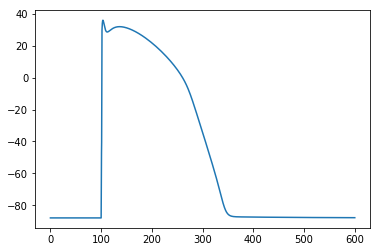

In [3]:
import matplotlib.pyplot as plt
import myokit
import numpy as np

# Load a CSV file
d = myokit.DataLog.load_csv('ap.csv')

# Convert Python lists to NumPy arrays
d = d.npview()

# Get time just after protocol is finished
tmax = d['engine.time'][-1] + 1

# Show the contents
print(d.keys())

times = d.time()
voltages = d['membrane.V']

plt.figure()
plt.plot(times, voltages)
plt.show()

Now, we use the data we loaded instead of a `myokit.Protocol` in a simulation, and compare the simulated voltage to the voltage in the CSV file:

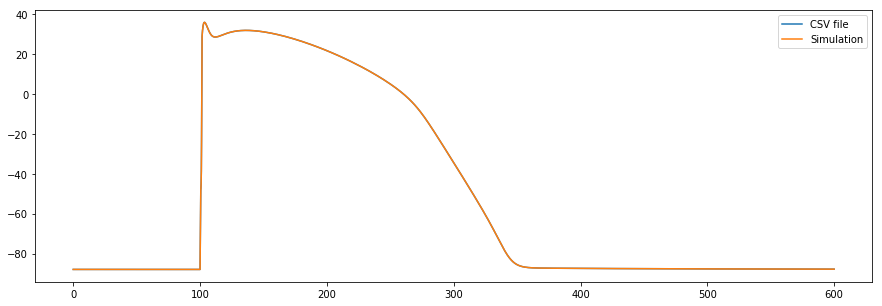

In [4]:
m = myokit.load_model('beattie-2017-ikr-hh.mmt')
s = myokit.Simulation(m)
s.set_fixed_form_protocol(times, voltages)

d = s.run(tmax+10, log_times=times)

plt.figure(figsize=(15, 5))
plt.plot(times, voltages, label='CSV file')
plt.plot(d.time(), d['membrane.V'], label='Simulation')
plt.legend()
plt.show()

Satisfied that these are similar (enough), we inspect the current under this protocol:

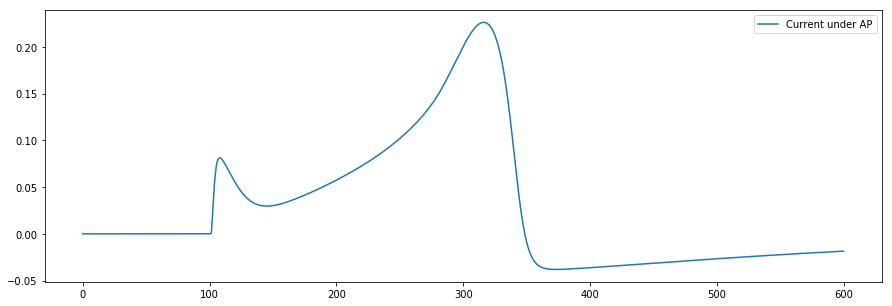

In [5]:
plt.figure(figsize=(15, 5))
plt.plot(d.time(), d['ikr.IKr'], label='Current under AP')
plt.legend()
plt.show()

## Using data-clamp for step protocols?

In the next example, we apply this method to a step/ramp protocol:

odict_keys(['time', 'voltage'])


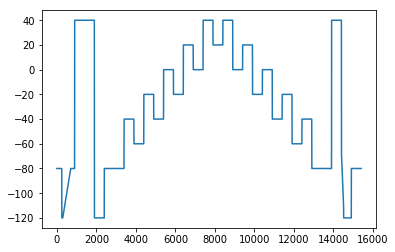

In [6]:
import matplotlib.pyplot as plt
import myokit
import numpy as np

# Load a CSV file
d = myokit.DataLog.load_csv('staircase-ramp.csv')

# Convert Python lists to NumPy arrays
d = d.npview()

# Convert time to ms
d['time'] *= 1000

# Get time just after protocol is finished
tmax = d['time'][-1] + 1

# Show the contents
print(d.keys())

times = d.time()
voltages = d['voltage']

plt.figure()
plt.plot(times, voltages)
plt.show()

Next, we apply this protocol in a simulation:

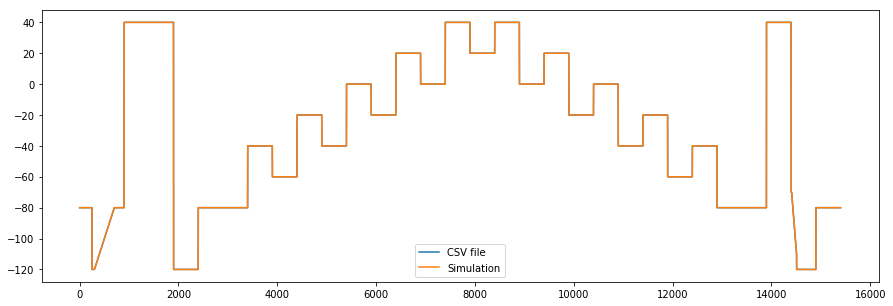

In [7]:
m = myokit.load_model('beattie-2017-ikr-hh.mmt')
s = myokit.Simulation(m)
s.set_fixed_form_protocol(times, voltages)

d = s.run(tmax+10, log_times=times)

plt.figure(figsize=(15, 5))
plt.plot(times, voltages, label='CSV file')
plt.plot(d.time(), d['membrane.V'], label='Simulation')
plt.legend()
plt.show()

At first glance, this looks okay.

But there are a few caveats / pitfalls:

### 1. The data-clamp signal is interpolated

This means that you can't use it to implement a sharp-discontinuity (unlike with myokit.Protocol, which is really a way of specifying discontinuities in your system).

We can see this by running a fine-grained simulation near a step change:

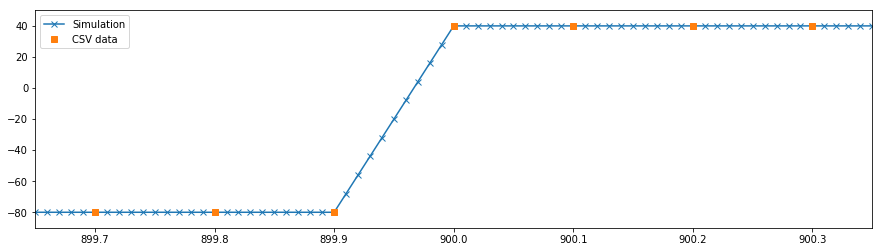

In [8]:
# Reset to initial time / initial state
s.reset()

# Simulate up until t=899.5ms, right before the first jump in voltage
s.run(899.5)
# Now log the next 1ms of the simulation, in great detail
d = s.run(1, log_interval=0.01)

plt.figure(figsize=(15,4))
plt.plot(d.time(), d['membrane.V'], 'x-', label='Simulation')
plt.plot(times, voltages, 's', label='CSV data')
plt.xlim(899.65, 900.35)
plt.ylim(-90, 50)
plt.legend()
plt.show()

As this plot shows, the simulation visits points between t=899.9 and t=900.0, for which the protocol provides no value. Since data clamp is intended for AP waveform signals, the behaviour of the simulation engine in these cases is to interpolate. This causes small (and hopefully transients) differences between the current elicited from a protocol implemented using data clamp or implemented using a `myokit.Protocol`.

### 2. With data-clamp, the solver doesn't stop at discontinuities

This is closely related to the previous point: When using a `myokit.Protocol`, the solver knows a priori where all discontinuities in the protocol are going to be. It uses this information to stop the ODE integration at each point a discontinuity occurs, reset itself, and then continue.

With protocols implemented as model equations or data-clamp, this knowledge is not available to the solver, and as a result it is no longer guaranteed to detect each discontinuity.

Let's look at some examples:

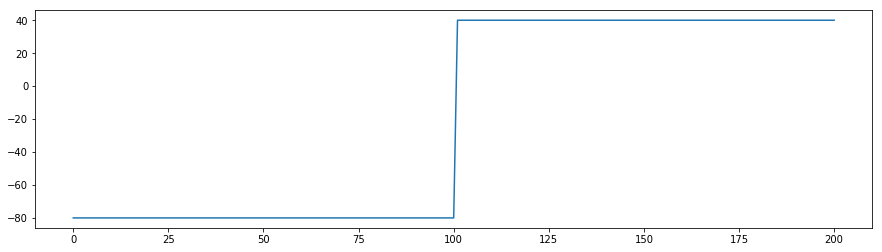

In [12]:
# Create a step protocol
times = [0, 100, 101, 200]
values = [-80, -80, 40, 40]

plt.figure(figsize=(15, 4))
plt.plot(times, values)
plt.show()

First, let's simulate the protocol above.

Unlike previous examples, we'll let the solver decide which points to log at. This means that every point the solver visits will show up as a point in the logs!

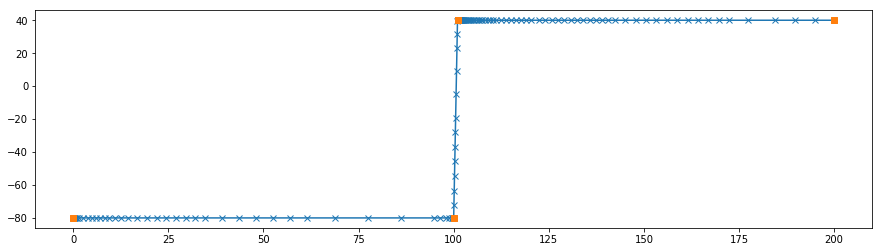

In [13]:
# Reset the simulator, and set the new protocol
s.reset()
s.set_fixed_form_protocol(times, values)

# Run a simulation, without specifying the points to log at.
d = s.run(200)

# Inspect the simulated voltage
plt.figure(figsize=(15, 4))
plt.plot(d.time(), d['membrane.V'], 'x-')
plt.plot(times, values, 's')
plt.show()

What does this plot show?

On the left, near t=0, we can see lots of points visited, as the solver carefully takes its first steps. The currents in the model will be slightly active at this point, which also contributes to the small step size.

As time passes, the model stabilised, and the solver reacts by making the step size larger.

At around t=90, the solver is taking lovely big steps (fast simulation!) and all is well. At this point it tries to jump beyond t=100, but it notices a rapid change in the system (as V is now +40). As a result, it backtraces to t=90, and starts taking much smaller steps.

Next, the solver hones in on the discontinuity: it keeps decreasing its step size, leading to lots of small steps near t=100ms.

After t=100ms, the current models are very active, leading to a prolonged period of short steps, but eventually the model calms down and the adaptive solver responds by increasing the step size again.

Yay!

**But will this always work?**

Let's try a short spike:

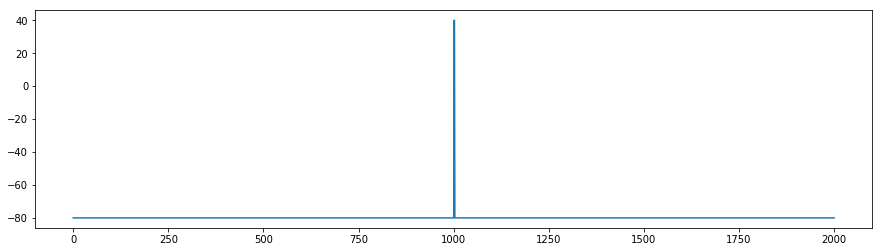

In [14]:
# Create a step protocol
times = [0, 1000, 1001, 1002, 1003, 2000]
values = [-80, -80, 40, 40, -80, -80]

plt.figure(figsize=(15, 4))
plt.plot(times, values)
plt.show()

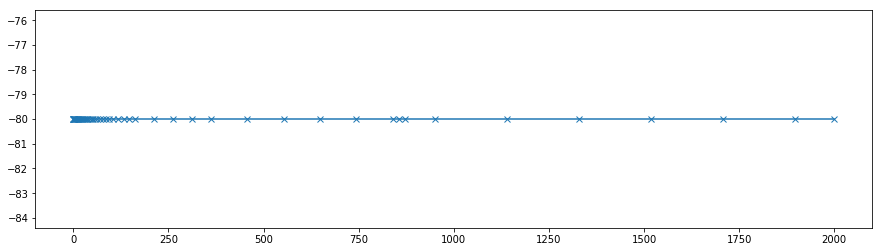

In [15]:
# Reset the simulator, and set the new protocol
s.reset()
s.set_fixed_form_protocol(times, values)

# Run a simulation, without specifying the points to log at.
d = s.run(2000)

# Inspect the simulated voltage
plt.figure(figsize=(15, 4))
plt.plot(d.time(), d['membrane.V'], 'x-')
plt.show()

Uh oh!

What's happened here?

The plot shows the solver stepped to a point around t=900ms, then tried a big step to around t=1150ms. Since V=-80 for both those points, it found no reason to question the result, and kept on going.

**How can we solve this?**

One strategy could be to manually stop the solver at each discontinuity:

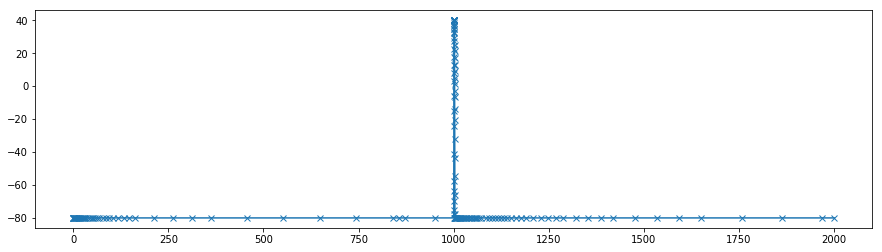

In [16]:
s.reset()
d = s.run(1000)
d = s.run(1, log=d)
d = s.run(1, log=d)
d = s.run(1, log=d)
d = s.run(997, log=d)

# Inspect the simulated voltage
plt.figure(figsize=(15, 4))
plt.plot(d.time(), d['membrane.V'], 'x-')
plt.show()

That works, but it does get a bit cumbersome for long protocols.

Another way around this is to set a maximum time step **that's no longer than the shortest step in the protocol**. In this case, 1ms should work:

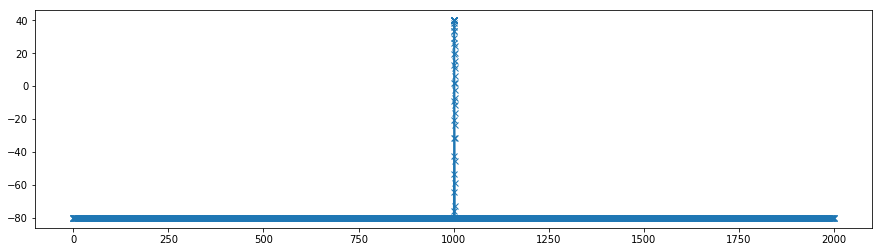

In [17]:
s.reset()
s.set_max_step_size(1)
d = s.run(2000)

# Inspect the simulated voltage
plt.figure(figsize=(15, 4))
plt.plot(d.time(), d['membrane.V'], 'x-')
plt.show()

This is a lot easier, but comes at a cost:

In [18]:
print('Time with AP clamp and maximum step size:')
s.set_max_step_size(1)
s.reset()
b = myokit.Benchmarker()
s.run(2000)
print(b.time())

print('Time with a protocol:')
p = myokit.Protocol()
p.add_step(-80, 1000)
p.add_step(40, 2)
p.add_step(-80, 1000)
s.set_protocol(p)

s.set_max_step_size(None)
s.reset()

b.reset()
s.run(2000)
print(b.time())

Time with AP clamp and maximum step size:
0.013712632000078884
Time with a protocol:
0.00503055400008634
